<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/main/code/basicGAN/basicGAN_cnn_global_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
from utils.tools import *

In [4]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [5]:
data = pd.read_table('./data/trips_SV_2008_formatted.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)
# colony =  (-32.392, -3.819)
data = format_data(data, colony, 30000)
data = data[data.dist_colony > 1000]

padding = 200
traj = padding_data(data, padding)

In [6]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        
        # select coordinates
        sample = self.traj[idx,:,:]

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [7]:
# hyperparameters
batch_size = 39
resolution = 60

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [8]:
x =  next(iter(train_loader))

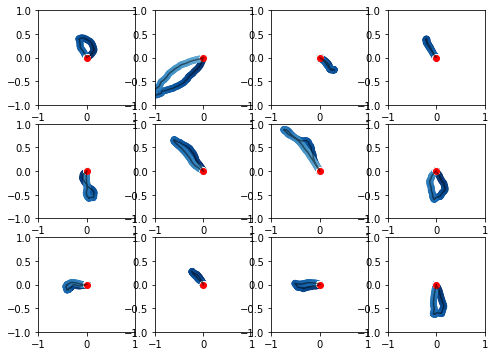

In [9]:
plt.figure(figsize = (8,8))
i = 4

for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


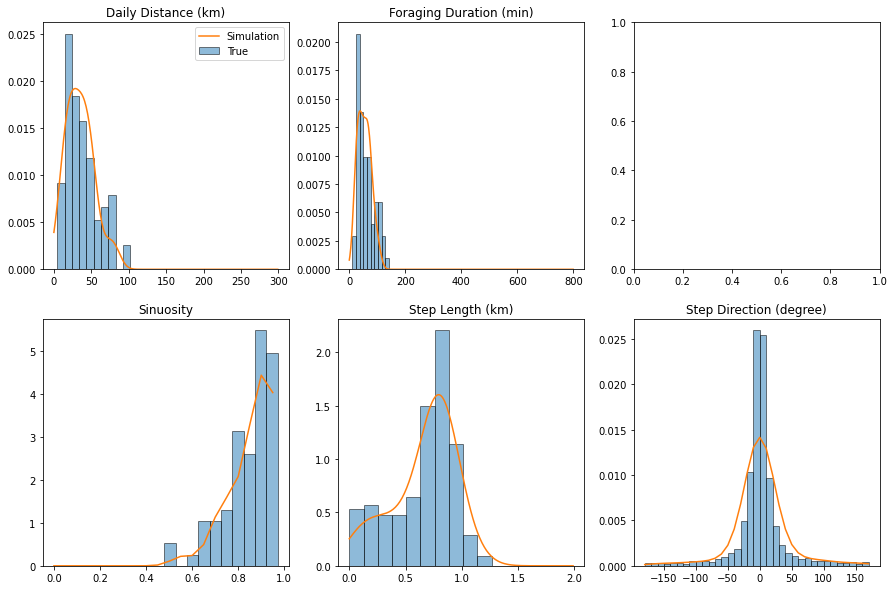

In [10]:
data_fake = format_simulation(x, colony, 30000)
data_fake = data_fake[data_fake.dist_colony > 1000]
get_score(data, data_fake)

## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [11]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z):    
        out = self.cnn(z)
        return out


# Idées réductions variabilité fine échelles
# - réduire taille vecteur de bruit : change pas grand chose
# - average pooling + forcer la régularité + upsampling
# - norme L1 fct de cout sur dérivées lon/lat
# - conv poids 1/n (forçage lissage) : ne marche pas dans le générateur(le réseau crée une variabilité + forte aux échelles supérieures)

In [13]:
z = torch.rand((batch_size, 256, 1))
gen = CNNGenerator()
gen(z).shape

torch.Size([39, 2, 200])

In [14]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):

        out = self.cnn(x)

        return out.squeeze(1)


In [15]:
dis = CNNDiscriminator()

In [16]:
dis(x).shape

torch.Size([39, 1])

# training

In [17]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = CNNGenerator().to(device)
discriminator = CNNDiscriminator().to(device)


### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

# w = torch.zeros((2,2,5))
# w[0,0,:] = 1/5
# w[1,1,:] = 1/5
# generator.smooth.weight.data = w

# for param in generator.smooth.parameters():
#   param.requires_grad = False

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

target_ones = torch.ones((batch_size, 1), device=device)
target_zeros = torch.zeros((batch_size, 1), device=device)

Epoch [1/5000] -----------------------------------------------------------------------------
G: 1.77, Dr : 0.87, Df : 1.58
Generator score : 20.51 %, Discriminator true positive : 97.44 %, Discriminator true negative : 48.72 %


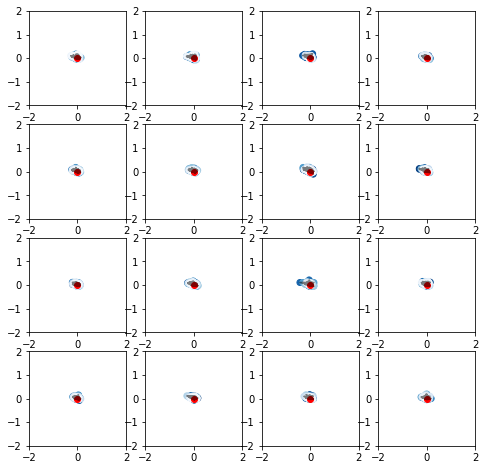

Epoch [501/5000] -----------------------------------------------------------------------------
G: 5.1, Dr : 0.62, Df : 0.2
Generator score : 17.95 %, Discriminator true positive : 97.44 %, Discriminator true negative : 97.44 %


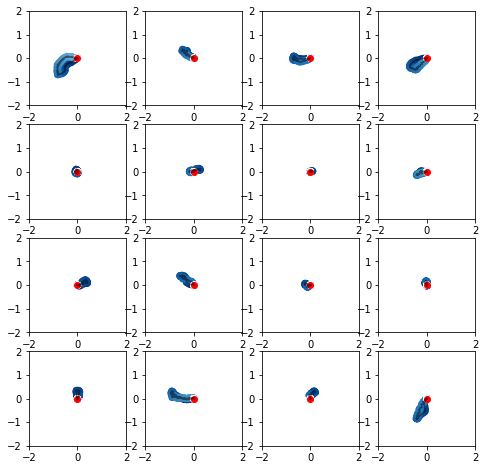

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 5.41, Dr : 0.19, Df : 0.31
Generator score : 10.26 %, Discriminator true positive : 97.44 %, Discriminator true negative : 94.87 %


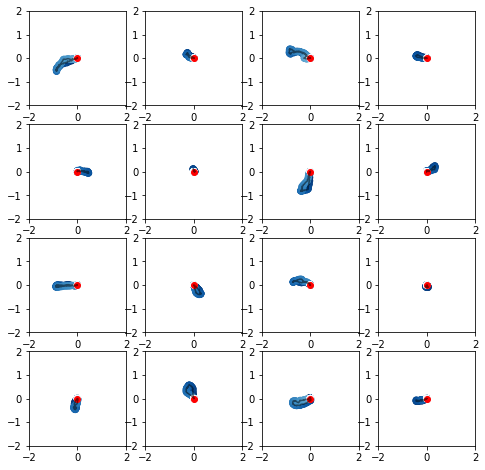

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 7.76, Dr : 0.17, Df : 0.13
Generator score : 2.56 %, Discriminator true positive : 100.0 %, Discriminator true negative : 100.0 %


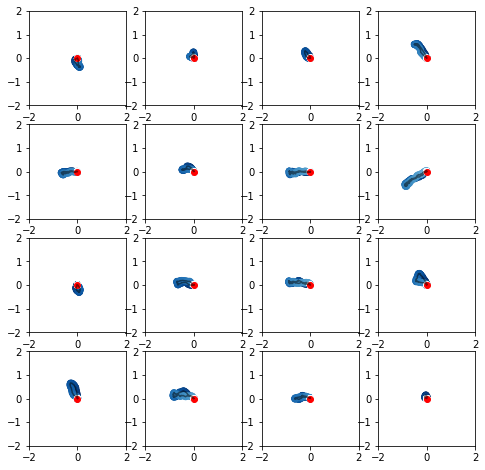

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 10.7, Dr : 0.17, Df : 0.07
Generator score : 0.0 %, Discriminator true positive : 100.0 %, Discriminator true negative : 100.0 %


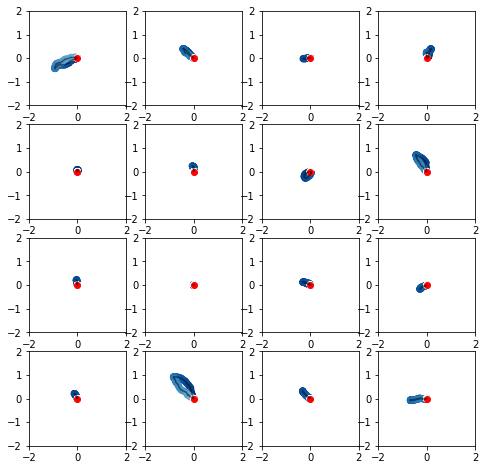

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 7.3, Dr : 0.01, Df : 0.27
Generator score : 0.0 %, Discriminator true positive : 100.0 %, Discriminator true negative : 97.44 %


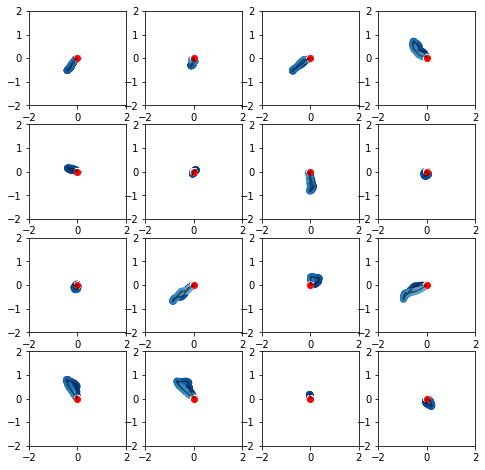

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 7.41, Dr : 0.31, Df : 0.43
Generator score : 5.13 %, Discriminator true positive : 84.62 %, Discriminator true negative : 97.44 %


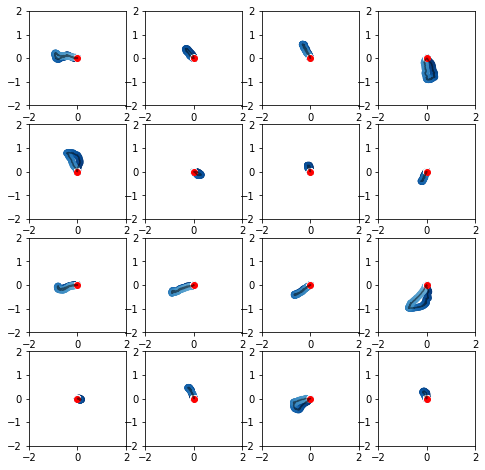

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 9.52, Dr : 0.03, Df : 0.07
Generator score : 0.0 %, Discriminator true positive : 100.0 %, Discriminator true negative : 100.0 %


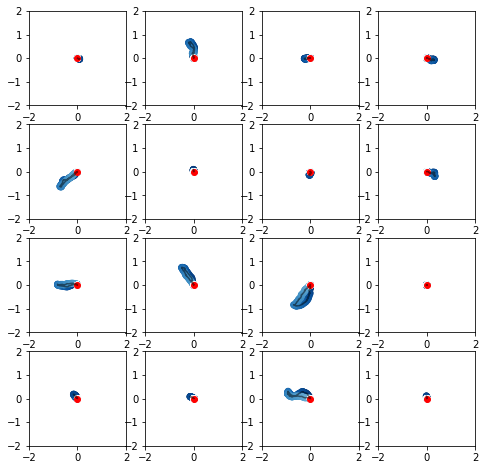

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 11.35, Dr : 0.08, Df : 0.04
Generator score : 0.0 %, Discriminator true positive : 100.0 %, Discriminator true negative : 100.0 %


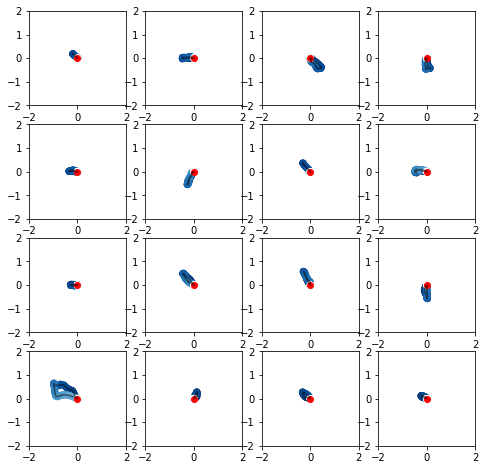

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 10.89, Dr : 0.02, Df : 0.03
Generator score : 0.0 %, Discriminator true positive : 100.0 %, Discriminator true negative : 100.0 %


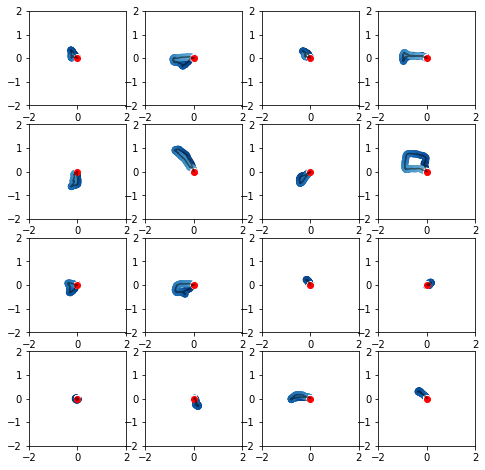

In [20]:
# Train the model
nb_epoch = 5000
score = []

for epoch in range(nb_epoch):
    i = 0

    # if epoch%100 == 0:
    #     lr /= 10
    #     optim_d = optim.Adam(discriminator.parameters(), lr=lr)
    #     optim_g = optim.Adam(generator.parameters(),lr=lr)

    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        i+= 1
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        # score discriminator
        score_d_fake = np.mean(pred_fake.detach().numpy()<0.5)
        score_d_real = np.mean(pred_real.detach().numpy()>0.5)

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) 
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()

        # score generator
        score_g = np.mean(classifications.detach().numpy()>0.5)
    

    if epoch%500 == 0:
        print('Epoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch, 2), np.round(loss_d_real_running/batch, 2), np.round(loss_d_fake_running/batch, 2)))
        print('Generator score : {} %, Discriminator true positive : {} %, Discriminator true negative : {} %'
            .format(np.round(score_g*100, 2), np.round(score_d_real*100, 2), np.round(score_d_fake*100, 2)))
        

        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj = generated.detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj[i,0,:], traj[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj[i,0,:], traj[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

In [21]:
class Smoother(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = nn.Conv1d(2,2, kernel_size = 5, stride = 1, padding = 2, bias = False)

    def forward(self, z):    
        out = self.smooth(z)
        return out

sm = Smoother()

for param in sm.smooth.parameters():
  param.requires_grad = False

w = torch.zeros((2,2,5))
w[0,0,:] = 1/5
w[1,1,:] = 1/5

sm.smooth.weight.data = w

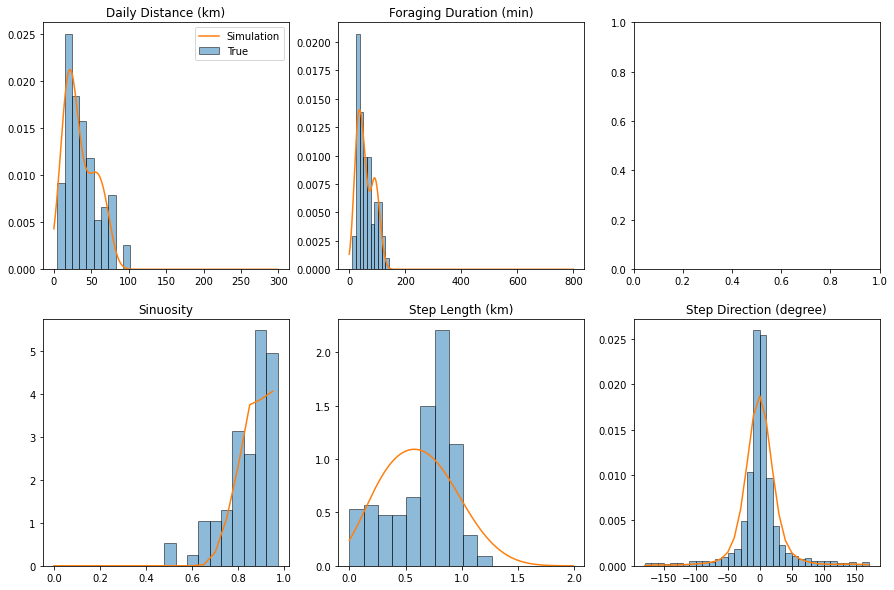

In [22]:
z = torch.randn((batch_size, 256, 1), device=device)
generated = generator(z)

data_fake = format_simulation(sm(generated), colony, 30000)
data_fake = data_fake[data_fake.dist_colony > 1000]

get_score(data, data_fake)
plt.show()
plt.close()

In [23]:
torch.save(generator, 'basicGAN_cnn_G_SV.pt')
torch.save(discriminator, 'basicGAN_cnn_D_SV.pt')

# generator = torch.load('basicGAN_cnn_G.pt')
# discriminator = torch.load('basicGAN_cnn_D.pt')

## visualizing

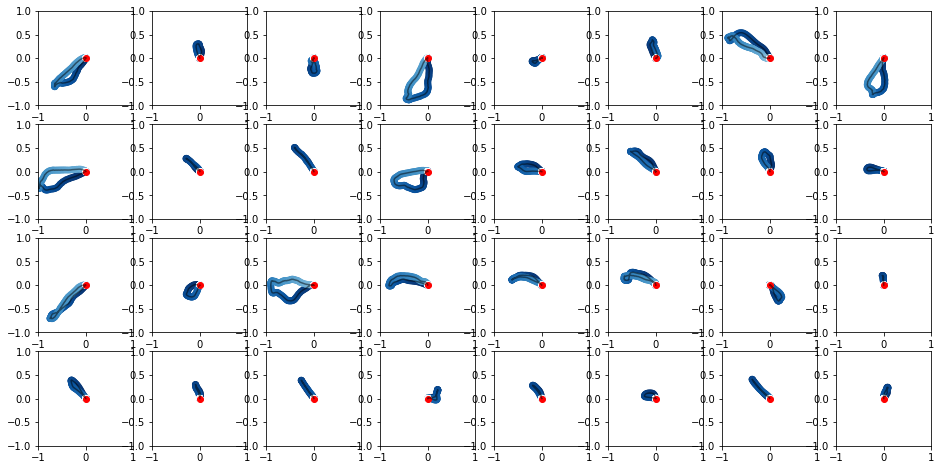

In [24]:
traj = sm(generated).detach().numpy()

plt.figure(figsize = (16,8))

for i in range(32):
  plt.subplot(4,8,i+1)
  plt.plot(traj[i,0,:], traj[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj[i,0,:], traj[i,1,:], c=np.arange(padding), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)